## ***Vasilii Mosin***

# Collaborative Filtering with Alternating Least Squares algorithm on Spark

In this homework the task is to implement the ALS algorithm on Spark and test it on the small Movie Lens dataset.

I know that we are required to use only plain Spark. However, unfortunately I was not be able to implement this algorithm from scratch because Spark is a new thing for me and it was not much time to deal with it. So, I present my homework using Spark one library. I was searching for the best parameters for ALS algorithm here and tested it on the Movie Lens.

I understand that this was not the task and it can be no points for such homework, but anyway I want to show that I tried to did something with Spark.

Creating an RDD for ratings..

In [2]:
ratings_raw_data = sc.textFile("ml-latest-small/ratings.csv")
ratings_raw_data_header = ratings_raw_data.take(1)[0]
ratings_data = ratings_raw_data.filter(lambda line: line!=ratings_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()

The RDD has the following form of triples: (user_id, item_id, rating).

In [3]:
ratings_data.take(7)

[(1, 31, 2.5),
 (1, 1029, 3.0),
 (1, 1061, 3.0),
 (1, 1129, 2.0),
 (1, 1172, 4.0),
 (1, 1263, 2.0),
 (1, 1287, 2.0)]

Splitting data on train and test (80:20)..

In [ ]:
training_RDD, test_RDD = ratings_data.randomSplit([8, 2], seed=0L)
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

Trying to find the best rank and regularization parameters for ALS wrt RMSE..

In [23]:
from pyspark.mllib.recommendation import ALS
import math
regularization_parameters = [0.001, 0.01, 0.1, 0.5, 0.9]
ranks = [4, 8, 12, 17, 19, 21, 28, 36]
errors = []
for regularization_parameter in regularization_parameters:
    err = []
    for rank in ranks:
        model = ALS.train(training_RDD, rank=rank, iterations=20, lambda_=regularization_parameter)
        predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
        rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
        error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        err.append(error)
    errors.append(err)

Plotting the results..

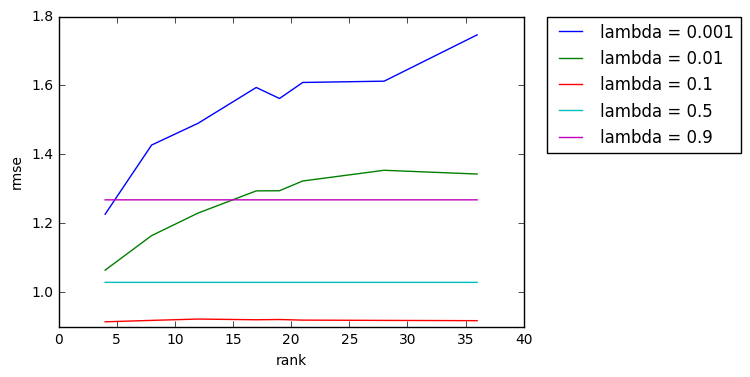

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 0
for errs in errors:
    plt.plot(ranks, errs, label='lambda = '+str(regularization_parameters[i]))
    i = i + 1
plt.xlabel("rank")
plt.ylabel("rmse")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As we can see from the plot the best rmse achieved with lambda = 0.1. It is almost no any dependency on the number of latent variables for lambdas 0.1, 0.5, 0.9. Controversly, for lambdas 0.001 and 0.01 rmse increases with increasing of the number of latent variables.

In [36]:
print "The best rmse on the test data is "+str(min(errors[2]))

The best rmse on the test data is 0.913619125718
